In [1]:
import pandas as pd
import numpy as np
from gravity_utils import *
import datetime

In [2]:
pd.set_option('display.max_rows', 1398)
pd.set_option('display.max_columns', 1398)

In [3]:
import shapefile
import shapely.wkt

In [4]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn import metrics
import statsmodels.api as sm
from scipy import stats
import stat
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, MinMaxScaler
from sklearn.metrics import r2_score, log_loss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso

In [5]:
def print_stats (model, X, y):
    """Prints coefficients, t-values and probabilities P value?"""
    lm = model
#     params = np.append(lm.intercept_,lm.coef_)
    params = lm.coef_
    predictions = lm.predict(X)

    # newX = pd.DataFrame({"Constant":np.ones(len(X))}, index = X.index).join(pd.DataFrame(X))
#     newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X.reset_index(drop=True)))
    newX = pd.DataFrame(X.reset_index(drop=True))
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

    # Note if you don't want to use a DataFrame replace the two lines above with
    # newX = np.append(np.ones((len(X),1)), X, axis=1)
    # MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,5)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilites"] = [params,sd_b,ts_b,p_values]
#     myDF3.index = np.append(['intercept_'], X.columns.values)
    myDF3.index = X.columns.values
    print(myDF3)

In [6]:
sams_w_nbuildings = pd.read_csv('data/GIS/B1_samsSW_20131231_shp/B1_sams_with_nbuildings.csv', sep=';', index_col=0)
sams_w_nbuildings['SAMSCODE'] = sams_w_nbuildings.SAMSCODE.astype(int)
sams_w_nbuildings['KOMMUN'] = sams_w_nbuildings.KOMMUN.astype(int)

In [7]:
resfil_raw = pd.read_csv('data/rvu/RVU_resfil.csv')
upsampled_resfil = draw_population(resfil_raw, resfil_raw.individvikt.astype(int))
upsampled_resfil = upsampled_resfil[(upsampled_resfil['ärende_2'] == 1)] 

# attraction_rvu = upsampled_resfil[(upsampled_resfil['rf4_komkod'] < 2000) &
#                                     (upsampled_resfil['rf4_komkod'] > 100)].groupby('rf4_komkod')['Id'].count()
# production_rvu = upsampled_resfil[(upsampled_resfil['rf1_komkod'] < 2000) &
#                                     (upsampled_resfil['rf1_komkod'] > 100)].groupby('rf1_komkod')['Id'].count()

# production_rvu_sams = upsampled_resfil[(upsampled_resfil['rf1_komkod'] < 2000) &
#                                     (upsampled_resfil['rf1_komkod'] > 100)].groupby('rf1_Samskod')['Id'].count()
# attraction_rvu_sams = upsampled_resfil[(upsampled_resfil['rf4_komkod'] < 2000) &
#                                     (upsampled_resfil['rf4_komkod'] > 100)].groupby('rf4_Samskod')['Id'].count()

In [8]:
resfil_tours_raw = resfil_raw[resfil_raw['ärende_2'] == 1].drop_duplicates(subset=['Id'], keep='first')
upsampled_resfil_tours = draw_population(resfil_tours_raw, resfil_tours_raw.individvikt.astype(int))

attraction_rvu = upsampled_resfil_tours[(upsampled_resfil_tours['rf4_komkod'] < 2000) &
                                    (upsampled_resfil_tours['rf4_komkod'] > 100)].groupby('rf4_komkod')['Id'].count()
production_rvu = upsampled_resfil_tours[(upsampled_resfil_tours['rf1_komkod'] < 2000) &
                                    (upsampled_resfil_tours['rf1_komkod'] > 100)].groupby('rf1_komkod')['Id'].count()

production_rvu_sams = upsampled_resfil_tours[(upsampled_resfil_tours['rf1_komkod'] < 2000) &
                                    (upsampled_resfil_tours['rf1_komkod'] > 100)].groupby('rf1_Samskod')['Id'].count()
attraction_rvu_sams = upsampled_resfil_tours[(upsampled_resfil_tours['rf4_komkod'] < 2000) &
                                    (upsampled_resfil_tours['rf4_komkod'] > 100)].groupby('rf4_Samskod')['Id'].count()

In [9]:
production_raw_rvu = resfil_tours_raw[(resfil_tours_raw['ärende_2'] == 1) &
                                (resfil_tours_raw['rf1_komkod'] < 2000) &
                                (resfil_tours_raw['rf1_komkod'] > 100)].groupby('rf1_Samskod')['Id'].count()
attraction_raw_rvu = resfil_tours_raw[(resfil_tours_raw['ärende_2'] == 1) &
                                (resfil_tours_raw['rf4_komkod'] < 2000) &
                                (resfil_tours_raw['rf4_komkod'] > 100)].groupby('rf4_Samskod')['Id'].count()

In [10]:
rvu_vs_scb = pd.DataFrame([production_raw_rvu, 
                           sams_w_nbuildings.set_index('SAMSCODE').TotBef, 
                           production_raw_rvu / sams_w_nbuildings.set_index('SAMSCODE').TotBef,
                           production_rvu_sams
                          ], 
             index=['rvu', 'sams', 'ratio', 'upsampled_rvu']).T.sort_values(['ratio'], ascending=False)

# sams_ids = rvu_vs_scb[(rvu_vs_scb['ratio'] < 10) & (rvu_vs_scb['ratio'] > 0.03) & (rvu_vs_scb['rvu'] > 5)]
# sams_index = sams_ids.index
sams_index = sams_w_nbuildings.SAMSCODE.values

In [11]:
a2 = read_shapefile('data/GIS/A2_samsSW_2012_shp/A2_sw_region.shp')
a2['KOMMUN'] = a2.KOMMUN.astype(int)
a2['SAMSCODE'] = a2.SAMSCODE.astype(int)
night_pop = a2[(a2.KOMMUN > 1200) & (a2.KOMMUN < 1300)]
# target_night_pop = night_pop.loc[(night_pop.KOMMUN == 1265) | (night_pop.KOMMUN == 1270)]
target_night_pop = night_pop.set_index('SAMSCODE').loc[sams_index].reset_index()
target_night_pop = target_night_pop.groupby(['SAMSCODE'])[['Totalt', 'Offentliga', 'Naringsliv']].sum()
target_night_pop.columns=[u'TotaltA2', u'OffentligaA2', u'NaringslivA2']
# other_night_pop = night_pop.loc[(night_pop.KOMMUN != 1265) & (night_pop.KOMMUN != 1270)]
other_night_pop = night_pop
other_night_pop = other_night_pop.groupby(['KOMMUN'])[['Totalt', 'Offentliga', 'Naringsliv']].sum()
other_night_pop.columns=[u'TotaltA2', u'OffentligaA2', u'NaringslivA2']

a4 = read_shapefile('data/GIS/A4_samsSW_2012_shp/A4_sw_region.shp')
a4['KOMMUN'] = a4.KOMMUN.astype(int)
a4['SAMSCODE'] = a4.SAMSCODE.astype(int)
a4 = a4[(a4.KOMMUN > 1200) & (a4.KOMMUN < 1300)]
target_day_pop = a4.set_index('SAMSCODE').loc[sams_index].reset_index()
# target_day_pop = a4.loc[(a4.KOMMUN == 1265) | (a4.KOMMUN == 1270)]
target_day_pop = target_day_pop.groupby(['SAMSCODE'])[['Totalt', 'Offentliga', 'Naringsliv']].sum()
target_day_pop.columns=[u'TotaltA4', u'OffentligaA4', u'NaringslivA4']
other_day_pop = a4
# other_day_pop = a4.loc[(a4.KOMMUN != 1265) & (a4.KOMMUN != 1270)]
other_day_pop = other_day_pop.groupby(['KOMMUN'])[['Totalt', 'Offentliga', 'Naringsliv']].sum()
other_day_pop.columns=[u'TotaltA4', u'OffentligaA4', u'NaringslivA4']

# target_buildings = sams_w_nbuildings.loc[(sams_w_nbuildings.KOMMUN == 1265) | (sams_w_nbuildings.KOMMUN == 1270)]
target_buildings = sams_w_nbuildings.set_index('SAMSCODE').loc[sams_index].reset_index()
target_buildings = target_buildings.groupby(['SAMSCODE']).sum()
# other_buildings = sams_w_nbuildings.loc[(sams_w_nbuildings.KOMMUN != 1265) & (sams_w_nbuildings.KOMMUN != 1270)]
other_buildings = sams_w_nbuildings
other_buildings = other_buildings.groupby(['KOMMUN']).sum()

#buildings = sams_w_nbuildings.groupby(['SAMSCODE'])['nProduction', 'nAttraction','TotBef', 'small_building', 'appt_build', 'multi_appartment_building'].sum()

In [12]:
production_sams_rvu = upsampled_resfil[(upsampled_resfil['ärende_2'] == 1) &
                                    (upsampled_resfil['rf1_komkod'] < 2000) &
                                    (upsampled_resfil['rf1_komkod'] > 100)].groupby('rf1_Samskod')['Id'].count()
production_kommun_rvu = upsampled_resfil[(upsampled_resfil['ärende_2'] == 1) &
                                    (upsampled_resfil['rf1_komkod'] < 2000) &
                                    (upsampled_resfil['rf1_komkod'] > 100)].groupby('rf1_komkod')['Id'].count()

In [13]:
target_x_sams = pd.concat([target_night_pop, target_buildings, target_day_pop], axis=1).sort_index()
other_x_sams = pd.concat([other_night_pop, other_buildings, other_day_pop], axis=1).sort_index()

all_x_sams = pd.concat([target_x_sams, other_x_sams]).sort_index()

# all_y_prod = pd.concat([target_night_pop, other_night_pop])
# all_y_att = pd.concat([target_day_pop, other_day_pop])

kommun_rvu_prod = production_kommun_rvu.sort_index()
sams_rvu_prod = production_sams_rvu.loc[sams_index].sort_index()

all_y_prod = pd.concat([kommun_rvu_prod, sams_rvu_prod]).sort_index()

/home/ai6644/anaconda3/envs/jup/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.
/home/ai6644/anaconda3/envs/jup/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  # Remove the CWD from sys.path while we load stuff.


In [14]:
other_trip_scb_2018 = pd.read_csv('data/coomuting_municipalities_2018.csv', sep=';', header=[0], index_col=[0])
other_trip_scb_2018['production'] = other_trip_scb_2018['Outgoing commuters'] + other_trip_scb_2018['Work and live in county/municipality']
other_trip_scb_2018['attraction'] = other_trip_scb_2018['Incomming commuters'] + other_trip_scb_2018['Work and live in county/municipality']
other_trip_scb_2003 = pd.read_csv('data/coomuting_municipalities_2013.csv', sep=';', header=[0], index_col=[0])
other_trip_scb_2003['production'] = other_trip_scb_2003['Comuters leaving the municipality'] + other_trip_scb_2003['Working and living in the municipality']
other_trip_scb_2003['attraction'] = other_trip_scb_2003['Comuters coming into the municipality'] + other_trip_scb_2003['Working and living in the municipality']

In [15]:
other_trip_scb_2003 = other_trip_scb_2003.dropna()
other_trip_scb_2018 = other_trip_scb_2018.dropna()

In [16]:
other_trip_scb_raw = \
pd.concat([other_trip_scb_2018.production - (other_trip_scb_2018.production - other_trip_scb_2003.production)*5/15,
           other_trip_scb_2018.attraction - (other_trip_scb_2018.attraction - other_trip_scb_2003.attraction)*5/15,
           other_trip_scb_2018['Outgoing commuters'] - (other_trip_scb_2018['Outgoing commuters'] - other_trip_scb_2003['Comuters leaving the municipality'])*5/15,
           other_trip_scb_2018['Incomming commuters'] - (other_trip_scb_2018['Incomming commuters'] - other_trip_scb_2003['Comuters coming into the municipality'])*5/15,
           other_trip_scb_2018['Work and live in county/municipality'] - (other_trip_scb_2018['Work and live in county/municipality'] - other_trip_scb_2003['Working and living in the municipality'])*5/15,
          ],
         axis=1)
other_trip_scb_raw.columns=['production', 'attraction', 'outgoing', 'incomming', 'within']

In [17]:
other_trip_scb_raw

,production,attraction,outgoing,incomming,within
County/Municipality,,,,,
1214,6420.666667,3998.666667,4008.333333,1586.333333,2412.333333
1230,11115.000000,6318.333333,8450.666667,3654.000000,2664.333333
1231,7476.333333,8257.000000,5501.000000,6281.666667,1975.333333
1233,16125.333333,8499.000000,11189.666667,3563.333333,4935.666667
1256,6280.333333,4848.666667,2911.333333,1479.666667,3369.000000
1257,4457.000000,3883.000000,1910.333333,1336.333333,2546.666667
1260,6609.333333,4803.666667,4040.666667,2235.000000,2568.666667
1261,14433.333333,7940.000000,9982.666667,3489.333333,4450.666667
1262,10470.000000,5527.000000,8099.000000,3156.000000,2371.000000


In [18]:
avg_day_c = production_kommun_rvu.sum() / other_trip_scb_raw.production.sum()
avg_day_c
other_trip_scb = other_trip_scb_raw*avg_day_c

In [19]:
avg_day_c

0.651633045730121

# Production linear regression

In [20]:
lin = Lasso(alpha=0.001,precompute=True,max_iter=10000, fit_intercept=False,
            positive=True, random_state=42, selection='random')

# lin = LinearRegression(fit_intercept=False, )

x_prod = other_x_sams.drop(axis=1, labels=['OffentligaA4','Ald25_44','TotBef', 'appt_build','multi_appartment_building','small_building','Ald65_W','Ald45_64','TotaltA2','Ald20_24','nIndustri','nEkonomi','TotaltA4','Ald16_19','Ald7_15','Ald0_6','nProduction','nAttraction','SAMSCODE'])
y_prod = other_trip_scb.production

# x_prod = other_x_sams.drop(axis=1, labels=['Ald20_24','TotBef','Ald65_W','Ald7_15','multi_appartment_building','nEkonomi','nIndustri','nProduction','appt_build','nAttraction','Ald16_19','Ald0_6','SAMSCODE', 'TotaltA2', 'OffentligaA2', 'NaringslivA2', 'TotaltA4', 'OffentligaA4', 'NaringslivA4'])
# y_prod = other_night_pop.TotaltA2

# x_prod = x_prod.drop(labels=[1280,1281,1283,1290,1292, 1293])
# y_prod = y_prod.drop(labels=[1280,1281,1283,1290,1292, 1293])

scaler_prod = StandardScaler(with_std=False, with_mean=False)
# scaler_att = Normalizer()
# scaler_att = MinMaxScaler()
scaler_prod.fit(x_prod)

X_prod = pd.DataFrame(scaler_prod.transform(x_prod), columns=x_prod.columns, index=x_prod.index)
production_model = lin.fit(X_prod, y_prod)
train_prod_pred = production_model.predict(X_prod)
score = r2_score(y_prod, train_prod_pred)
print('R**2 value')
print(score)
# print(pd.DataFrame(production_model.coef_, index=X_prod.columns))
print_stats(production_model, X_prod, y_prod)

R**2 value
0.9998860706634678
              Coefficients  Standard Errors  t values  Probabilites
OffentligaA2        0.5158            0.018    28.324       0.00000
NaringslivA2        0.6993            0.010    68.610       0.00000
NaringslivA4        0.0372            0.008     4.939       0.00002


In [21]:
pred_prod_sams = pd.DataFrame(
    production_model.predict(scaler_prod.transform(target_x_sams.loc[:, X_prod.columns])), 
    index=target_x_sams.index,
    columns=['trips']
)

In [22]:
pred_prod_sams.describe()

,trips
count,1397.000000
mean,271.495619
std,291.146924
min,0.000000
25%,66.158824
50%,184.282246
75%,371.860304
max,2377.125475


In [23]:
kommun_to_sams = sams_w_nbuildings.groupby(['KOMMUN'])['SAMSCODE'].unique()
predicted_kommun_trips_from_sams = \
    pd.DataFrame([pred_prod_sams.loc[samses].sum().values for _, samses in kommun_to_sams.iteritems()], 
                 index=kommun_to_sams.index, columns=['trips_sams'])
predicted_kommun_trips_from_sams = predicted_kommun_trips_from_sams.join(other_trip_scb.production)

In [24]:
r2_score(predicted_kommun_trips_from_sams.trips_sams, predicted_kommun_trips_from_sams.production)

0.9998854928896254

In [25]:
(predicted_kommun_trips_from_sams.trips_sams / predicted_kommun_trips_from_sams.production).describe()

count    33.000000
mean      1.012254
std       0.020275
min       0.986399
25%       0.997900
50%       1.008151
75%       1.021808
max       1.056983
dtype: float64

# Attraction Linear regression

In [26]:
from sklearn.linear_model import Lasso
lin = Lasso(alpha=0.001,precompute=True,max_iter=10000, fit_intercept=False,
            positive=True, random_state=42, selection='random')

x_att = other_x_sams.drop(axis=1, labels=['TotBef', 'SAMSCODE', 'Ald0_6', 'nProduction', 'nAttraction', 'multi_appartment_building', 'small_building', 'TotaltA2', 'OffentligaA2', 'NaringslivA2', 'Ald7_15', 'Ald16_19', 'Ald20_24','appt_build', 'Ald65_W', 'Ald45_64','TotaltA4', 'nEkonomi'])
y_att = other_trip_scb.attraction

# x_att = x_att.drop(labels=[1280,1281,1283,1290,1292, 1293])
# y_att = y_att.drop(labels=[1280,1281,1283,1290,1292, 1293])

# x_att_s = x_att.append(pd.DataFrame(np.zeros(len(x_att.columns)), index=x_att.columns).T)
scaler_att = StandardScaler(with_std=False, with_mean=False)
# scaler_att = Normalizer()
# scaler_att = MinMaxScaler()
scaler_att.fit(x_att)

X_att = pd.DataFrame(scaler_att.transform(x_att), columns=x_att.columns, index=x_att.index)
attraction_model = lin.fit(X_att, y_att)
train_att_pred = attraction_model.predict(X_att)
score = r2_score(y_att, train_att_pred)
print('R**2 value')
print(score)
print_stats(attraction_model, X_att, y_att)

R**2 value
0.9997709289511443
              Coefficients  Standard Errors  t values  Probabilites
Ald25_44            0.2051            0.029     7.003       0.00000
nIndustri           0.9510            0.197     4.833       0.00003
OffentligaA4        0.6471            0.025    25.617       0.00000
NaringslivA4        0.5360            0.026    20.234       0.00000


In [27]:
pred_att_sams = pd.DataFrame(
    attraction_model.predict(scaler_att.transform(target_x_sams.loc[:, X_att.columns])), 
    index=target_x_sams.index,
    columns=['trips']
)
pred_att_sams.describe()

,trips
count,1397.000000
mean,267.022473
std,454.666141
min,0.000000
25%,52.485378
50%,133.370841
75%,310.093441
max,5985.384590


In [28]:
pred_att_sams.loc[12650000:12659999].sum()

trips    4208.86583
dtype: float64

In [29]:
y_att[1265]

3975.3960009842253

In [30]:
pred_prod_sams.loc[12650000:12659999].sum()

trips    5962.677432
dtype: float64

In [31]:
y_prod[1265]

5729.157738059224

In [32]:
kommun_to_sams = sams_w_nbuildings.groupby(['KOMMUN'])['SAMSCODE'].unique()
predicted_kommun_trips_from_sams = \
    pd.DataFrame([pred_att_sams.loc[samses].sum().values for _, samses in kommun_to_sams.iteritems()], 
                 index=kommun_to_sams.index, columns=['trips_sams'])
predicted_kommun_trips_from_sams = predicted_kommun_trips_from_sams.join(other_trip_scb.attraction)

In [33]:
r2_score(predicted_kommun_trips_from_sams.trips_sams, predicted_kommun_trips_from_sams.attraction)

0.9997693393236631

In [34]:
(predicted_kommun_trips_from_sams.trips_sams / predicted_kommun_trips_from_sams.attraction).describe()

count    33.000000
mean      1.028054
std       0.052064
min       0.906502
25%       0.986583
50%       1.033069
75%       1.064003
max       1.153474
dtype: float64

# Gravity model for municipalities

# Gravity

In [35]:
sams_distance_matrix = pd.read_csv('data/sams_distance_matrix_with_kommun.csv', sep=';', index_col=[0])
sams_distance_matrix.columns = sams_distance_matrix.index
#the thing above is differently sorted
sams_distance_matrix = sams_distance_matrix.sort_index().T.sort_index().T

In [36]:
# sams_distance_matrix.replace(0, np.nan, inplace=True)
# for (idx, value) in sams_distance_matrix.loc[1200:1299, 1200:1299].min().iteritems():
#     sams_distance_matrix.at[int(idx), idx] = value * (1.0 / 3)
# for (idx, value) in sams_distance_matrix.loc[[1273, 1291], [1273, 1291]].min().iteritems():
#     sams_distance_matrix.at[int(idx), idx] = value * (1.0 / 2)

# sams_distance_matrix.at[12650001, 12650002] = sams_distance_matrix.loc[12650001].min() * (1.0 / 3)
# sams_distance_matrix.at[12650002, 12650001] = sams_distance_matrix.loc[12650002].min() * (1.0 / 3)
# sams_distance_matrix.at[12700020, 12700001] = sams_distance_matrix.loc[12700020].min() * (1.0 / 3)
# sams_distance_matrix.at[12700001, 12700020] = sams_distance_matrix.loc[12700001].min() * (1.0 / 3)
# for (idx, value) in sams_distance_matrix.loc[12650000:12659999, 12650000:12659999].min().iteritems():
#     sams_distance_matrix.at[int(idx), idx] = value * (1.0 / 3)
# for (idx, value) in sams_distance_matrix.loc[12700000:12709999, 12700000:12709999].min().iteritems():
#     sams_distance_matrix.at[int(idx), idx] = value * (1.0 / 3)
    
r = 4000
r1 = 4000
for (idx, value) in sams_distance_matrix.loc[1200:1299, 1200:1299].min().iteritems():
    sams_distance_matrix.at[int(idx), idx] = r
for (idx, value) in sams_distance_matrix.loc[12650000:12659999, 12650000:12659999].min().iteritems():
    sams_distance_matrix.at[int(idx), idx] = r1
for (idx, value) in sams_distance_matrix.loc[12700000:12709999, 12700000:12709999].min().iteritems():
    sams_distance_matrix.at[int(idx), idx] = r1
sams_distance_matrix.at[12650001, 12650002] = r
sams_distance_matrix.at[12650002, 12650001] = r
sams_distance_matrix.at[12700020, 12700001] = r
sams_distance_matrix.at[12700001, 12700020] = r

/home/ai6644/anaconda3/envs/jup/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ai6644/anaconda3/envs/jup/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1.42356e+05, 5.22730e+04, 3.19970e+04, 3.68230e+04, 1.30000e+04,
        1.43030e+04, 8.21800e+03, 9.40400e+03, 3.74800e+03, 4.40000e+03,
        3.20900e+03, 2.77400e+03, 1.12600e+03, 1.54800e+03, 4.25000e+02,
        6.59000e+02, 2.97000e+02, 3.79000e+02, 3.80000e+02, 2.18000e+02,
        8.00000e+01, 9.80000e+01, 2.15000e+02, 4.90000e+01, 0.00000e+00,
        0.00000e+00, 1.40000e+02, 6.30000e+01, 0.00000e+00, 7.10000e+01,
        2.60000e+01, 1.90000e+01, 0.00000e+00, 1.85000e+02, 5.40000e+01,
        1.10000e+01, 0.00000e+00, 7.40000e+01, 0.00000e+00, 1.00000e+01,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 4.50000e+01, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 4.30000e+01,
        0.00000e+00, 6.30000e+01, 0.00000e+00, 1.07000e+02, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 3.70000e+01,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

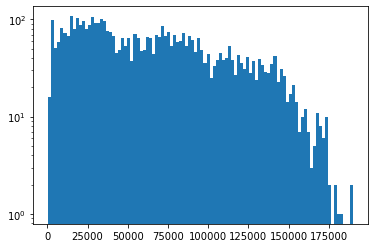

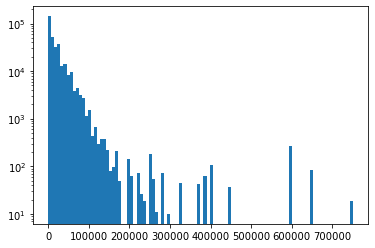

In [37]:
fig, ax = plt.subplots()
ax.hist(sams_distance_matrix.replace(np.inf, -10000).values.flatten(), 100, log=True)
_, ax = plt.subplots()
ax.hist(upsampled_resfil_tours['rf7_km']*1000, 100, log=True)

In [38]:
sams_distance_matrix

,1214,1230,1231,1233,1256,1257,1260,1261,1262,1263,1264,1266,1267,1272,1273,1275,1276,1277,1278,1280,1281,1282,1283,1284,1285,1286,1287,1290,1291,1292,1293,12650001,12650002,12650003,12650004,12650005,12650006,12650007,12650008,12650009,12650010,12650011,12650012,12650013,12650014,12650015,12650016,12650017,12700001,12700002,12700003,12700004,12700005,12700006,12700007,12700008,12700009,12700010,12700011,12700012,12700013,12700014,12700015,12700016,12700017,12700018,12700019,12700020
1214,4000.000,58784.132,52200.495,81825.859,93038.044,82323.480,27169.711,20220.946,40074.334,72573.799,87785.103,48005.889,42039.205,111510.657,121240.048,34479.419,64151.871,29270.803,84767.506,59569.604,39851.989,18644.179,47136.591,56600.728,22319.470,104313.499,90590.395,93300.285,121601.763,61901.267,66129.081,71164.415,71164.415,74971.089,74440.998,74932.576,79307.444,73428.722,71127.413,73507.168,84929.066,89744.257,89873.732,67024.055,66912.146,65741.418,56710.909,61496.938,101293.899,95285.781,89440.368,94877.121,93735.560,93217.721,94350.328,100618.368,99500.933,103298.618,105608.033,100066.418,85054.854,102935.751,85060.831,102371.287,109228.928,126244.285,120728.780,101293.899
1230,57588.199,4000.000,9076.159,34659.582,105249.768,104518.658,77749.261,28924.707,22820.228,25407.522,40618.826,46547.069,57467.691,110051.837,134646.311,101773.452,86347.049,78330.072,106962.684,17130.399,12981.293,44880.660,69331.769,78795.906,30253.395,57147.222,43424.118,91841.465,82818.348,84096.445,84617.266,32381.000,32381.000,36187.674,35657.583,36149.161,40524.029,34645.307,32343.998,47647.589,46145.651,50960.842,51090.317,50101.517,46738.112,40196.407,38955.435,40701.288,62510.484,56502.366,50656.953,56093.706,54952.145,54434.306,55566.913,61834.953,60717.518,64515.203,66824.618,61283.003,70665.238,64152.336,64419.722,74540.168,70445.513,79078.008,73562.503,62510.484
1231,51542.694,9739.653,4000.000,32781.380,108277.575,98473.153,71703.756,22879.202,16774.723,23529.320,38740.624,49574.876,60495.498,113079.644,137674.118,95727.947,80301.544,72284.567,100917.179,10435.661,16009.100,38835.155,63286.264,72750.401,33281.202,55269.020,41545.916,94869.272,91394.086,78050.940,87645.073,40956.738,40956.738,44763.412,44233.321,44724.899,49099.767,43221.045,40919.736,56223.327,54721.389,59536.580,59666.055,58677.255,55313.850,48772.145,47531.173,49277.026,76005.842,65078.104,59232.691,64669.444,63527.883,63010.044,64142.651,70410.691,69293.256,73090.941,75400.356,69858.741,79240.976,72728.074,72995.460,83115.906,83900.976,77199.806,71684.301,76005.842
1233,80778.487,33490.815,32266.447,4000.000,136506.250,127708.946,100939.549,52114.995,46010.516,33480.269,48691.573,77803.551,88724.173,141308.319,165902.793,124963.740,109537.337,101520.360,130152.972,24497.307,44237.775,68070.948,92522.057,101986.194,61509.877,65219.969,26538.494,123097.947,114888.807,107286.733,115873.748,64707.900,64707.900,68514.574,67984.483,68476.061,72850.929,66972.207,64670.898,79974.489,78472.551,83287.742,83417.217,82428.417,79065.012,72523.307,71282.335,73028.188,85956.791,82849.009,82983.853,88420.606,87022.604,86761.206,85958.394,94161.853,93044.418,96842.103,98895.077,93353.462,102992.138,96479.236,96746.622,106867.068,93851.925,87150.755,81635.250,85956.791
1256,106291.685,105218.131,107877.843,137464.978,4000.000,59466.989,80956.517,108153.937,107565.405,128212.918,143424.222,60741.189,54294.905,41166.948,43158.062,54492.267,78464.257,79172.655,91305.045,115134.693,94289.182,120842.312,98091.164,107569.844,94574.391,109185.384,146229.514,19231.819,85811.410,96032.978,24827.563,90906.624,90906.624,91092.240,90562.149,91053.727,95428.595,100930.123,98535.414,91086.274,88945.652,79800.677,79082.298,68315.260,84491.252,83320.524,82812.537,79076.044,88374.871,87288.438,84434.349,83297.300,83799.761,83868.158,84414.529,79626.761,74480.698,78620.097,87311.916,84039.763,64532.977,71045.878,67279.478,60658.047,93202.273,98883.011,93499.911,88374.871
1257,83221.733,105680.107,99096.470,12

In [39]:
target_x_sams = all_x_sams.loc[1200:1264].append([all_x_sams.loc[1266:1269], all_x_sams.loc[1271:1299],
                                                  all_x_sams.loc[12650000:12659999],all_x_sams.loc[12700000:12709999],])

In [40]:
pred_prod_sams = pd.DataFrame(production_model.predict(scaler_prod.transform(target_x_sams.loc[:, x_prod.columns])), index=target_x_sams.index, columns=['predicted_production']).sort_index()
pred_attr_sams = pd.DataFrame(attraction_model.predict(scaler_att.transform(target_x_sams.loc[:, x_att.columns])), index=target_x_sams.index, columns=['predicted_attraction']).sort_index()

# pred_attr_sams_b = pred_attr_sams * (pred_prod_sams.sum().values / pred_attr_sams.sum().values)

In [41]:
pred_prod_kommun = all_x_sams.loc[1200:1299].sort_index()
pred_prod_kommun = pd.DataFrame(production_model.predict(scaler_prod.transform(pred_prod_kommun.loc[:, x_prod.columns])), index=pred_prod_kommun.index, columns=['predicted_production']).sort_index()
pred_attr_kommun = all_x_sams.loc[1200:1299].sort_index()
pred_attr_kommun = pd.DataFrame(attraction_model.predict(scaler_att.transform(pred_attr_kommun.loc[:, x_att.columns])), index=pred_attr_kommun.index, columns=['predicted_attraction']).sort_index()

### Mean trip length from RVU

In [42]:
rvu_mtl = upsampled_resfil_tours['rf7_km'].mean() * 1000
print(rvu_mtl)

20698.241043536986


In [43]:
prodA = pred_prod_sams.values.flatten()
attrA = pred_attr_sams.values.flatten()
f = sams_distance_matrix.values
c=-0.00001
c2 = -0.1
cost_matrix = np.power(f, c2) * np.exp(c*f)
num_iter=10
num_iter_cal = 500
mtl = rvu_mtl
num_zones = len(prodA)
alpha = 0.1
f = f

trips = np.zeros((num_zones, num_zones))
print('Checking production, attraction balancing:')
sumP = sum(prodA)
sumA = sum(attrA)
print('Production: ', sumP)
print('Attraction: ', sumA)
if sumP != sumA:
    print('Productions and attractions do not balance, attractions will be scaled to productions!')
    attrA = attrA * (sumP / sumA)
    attrT = attrA.copy()
    prodT = prodA.copy()
else:
    print('Production, attraction balancing OK.')
    attrT = attrA.copy()
    prodT = prodA.copy()

trips = cost_matrix
#Run 2D balancing --->
computed_attractions = trips.sum(0)
computed_attractions[computed_attractions==0]=1
trips = trips * (attrT / computed_attractions)
# trips = trips.round(0)

computed_productions = trips.sum(1)
computed_productions[computed_productions==0]=1
trips = trips * np.reshape((prodT / computed_productions),[len(prodT),1])
# trips = trips.round(0)

for Iter in range(0, num_iter_cal):

    model_trip_len = np.nan_to_num(trips * f).sum() / trips.sum()
    c = c*(model_trip_len / mtl)**alpha
    cost_matrix = 0.2 * np.power(f, c2) * np.exp(c * f)
    for _ in range(0, num_iter):
        trips = cost_matrix
        #Run 2D balancing --->
        computed_attractions = trips.sum(0)
        computed_attractions[computed_attractions==0]=1
        trips = trips * (attrT / computed_attractions)
        trips = trips.round(0)

        computed_productions = trips.sum(1)
        computed_productions[computed_productions==0]=1
        trips = trips * np.reshape((prodT / computed_productions),[len(prodT),1])
#         trips = trips.round(0)
    print ('iteration: ', Iter, ' coefficient: ', c, ' average trip length (model): ', model_trip_len)

print ('target average trip length (observed): ', mtl) 
print ('final average trip length (model): ', model_trip_len)
print ('final logit scaling factor: ', c)

Checking production, attraction balancing:
Production:  379279.37912539067
Attraction:  373030.39418785437
Productions and attractions do not balance, attractions will be scaled to productions!
iteration:  0  coefficient:  -1.0911270632185118e-05  average trip length (model):  49509.29217817411
iteration:  1  coefficient:  -1.188281082094579e-05  average trip length (model):  48570.43505298841
iteration:  2  coefficient:  -1.291429487818311e-05  average trip length (model):  47582.64680731781
iteration:  3  coefficient:  -1.4004452802272033e-05  average trip length (model):  46546.5928202086
iteration:  4  coefficient:  -1.5150615671248436e-05  average trip length (model):  45454.283125520364
iteration:  5  coefficient:  -1.634930742270963e-05  average trip length (model):  44322.497737649406
iteration:  6  coefficient:  -1.759520934406446e-05  average trip length (model):  43140.405452751795
iteration:  7  coefficient:  -1.8882704980823464e-05  average trip length (model):  41940.2616

iteration:  116  coefficient:  -5.185663887714502e-05  average trip length (model):  20699.47594930448
iteration:  117  coefficient:  -5.1856934104588905e-05  average trip length (model):  20699.419454919127
iteration:  118  coefficient:  -5.185722850894713e-05  average trip length (model):  20699.416162767713
iteration:  119  coefficient:  -5.18574572922934e-05  average trip length (model):  20699.154225170034
iteration:  120  coefficient:  -5.185768525527682e-05  average trip length (model):  20699.15094663796
iteration:  121  coefficient:  -5.1857908444855245e-05  average trip length (model):  20699.131889540175
iteration:  122  coefficient:  -5.185811909091683e-05  average trip length (model):  20699.08181841309
iteration:  123  coefficient:  -5.185832973783407e-05  average trip length (model):  20699.08181841309
iteration:  124  coefficient:  -5.1858532176822586e-05  average trip length (model):  20699.04905347662
iteration:  125  coefficient:  -5.185858585560417e-05  average trip

iteration:  251  coefficient:  -5.185937581731554e-05  average trip length (model):  20698.243588309153
iteration:  252  coefficient:  -5.185937645490734e-05  average trip length (model):  20698.243588309153
iteration:  253  coefficient:  -5.185937709249915e-05  average trip length (model):  20698.243588309153
iteration:  254  coefficient:  -5.185937773009097e-05  average trip length (model):  20698.243588309153
iteration:  255  coefficient:  -5.18593783676828e-05  average trip length (model):  20698.243588309153
iteration:  256  coefficient:  -5.185937900527463e-05  average trip length (model):  20698.243588309153
iteration:  257  coefficient:  -5.185937964286647e-05  average trip length (model):  20698.243588309153
iteration:  258  coefficient:  -5.185938028045832e-05  average trip length (model):  20698.243588309153
iteration:  259  coefficient:  -5.1859380918050174e-05  average trip length (model):  20698.243588309153
iteration:  260  coefficient:  -5.185938155564204e-05  average t

iteration:  330  coefficient:  -5.185942618709206e-05  average trip length (model):  20698.243588309153
iteration:  331  coefficient:  -5.185942682468448e-05  average trip length (model):  20698.243588309153
iteration:  332  coefficient:  -5.185942746227691e-05  average trip length (model):  20698.243588309153
iteration:  333  coefficient:  -5.185942809986935e-05  average trip length (model):  20698.243588309153
iteration:  334  coefficient:  -5.185942873746179e-05  average trip length (model):  20698.243588309153
iteration:  335  coefficient:  -5.185942937505424e-05  average trip length (model):  20698.243588309153
iteration:  336  coefficient:  -5.1859430012646706e-05  average trip length (model):  20698.243588309153
iteration:  337  coefficient:  -5.1859430650239176e-05  average trip length (model):  20698.243588309153
iteration:  338  coefficient:  -5.185943128783165e-05  average trip length (model):  20698.243588309153
iteration:  339  coefficient:  -5.185943192542414e-05  average

iteration:  419  coefficient:  -5.185948293284826e-05  average trip length (model):  20698.243588309153
iteration:  420  coefficient:  -5.185948357044138e-05  average trip length (model):  20698.243588309153
iteration:  421  coefficient:  -5.185948420803451e-05  average trip length (model):  20698.243588309153
iteration:  422  coefficient:  -5.185948484562764e-05  average trip length (model):  20698.243588309153
iteration:  423  coefficient:  -5.185948548322078e-05  average trip length (model):  20698.243588309153
iteration:  424  coefficient:  -5.185948612081393e-05  average trip length (model):  20698.243588309153
iteration:  425  coefficient:  -5.185948675840709e-05  average trip length (model):  20698.243588309153
iteration:  426  coefficient:  -5.185948739600026e-05  average trip length (model):  20698.243588309153
iteration:  427  coefficient:  -5.1859488033593436e-05  average trip length (model):  20698.243588309153
iteration:  428  coefficient:  -5.185948867118662e-05  average 

In [44]:
filtered_resfil_tours = resfil_tours_raw[(resfil_tours_raw.rf1_Samskod > 1) & (resfil_tours_raw.rf4_Samskod > 1)]
filtered_resfil_tours.loc[:,'rf6_ankomsttid'] = filtered_resfil_tours.loc[:,'rf6_ankomsttid'].replace({'99':np.NaN})
filtered_resfil_tours = filtered_resfil_tours.dropna(subset=['rf2_starttid','rf6_ankomsttid', 'rf7_km'])
t1 = filtered_resfil_tours.rf2_starttid.apply(lambda t: datetime.datetime.strptime(t.strip(),'%H:%M'))
t2 = filtered_resfil_tours.rf6_ankomsttid.apply(lambda t: datetime.datetime.strptime(t.strip(),'%H:%M'))
t = t2-t1
t= t.apply(lambda x: x.seconds /60/60)
speed = filtered_resfil_tours.rf7_km / (t)
filtered_resfil_tours['speed'] = speed
filtered_resfil_tours = filtered_resfil_tours[filtered_resfil_tours.speed <= 100]
upsampled_resfil_tours = draw_population(filtered_resfil_tours, filtered_resfil_tours.individvikt.astype(int))

/home/ai6644/anaconda3/envs/jup/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [45]:
f = sams_distance_matrix.values
bins = [0., 7001, 19000, 30000, 50000, 10000000000]
binned_distances = np.digitize(f.flatten(), bins).reshape(len(f),len(f))
observed_tld, _ = np.histogram(filtered_resfil_tours.rf7_km * 1000, bins)
observed_tld = observed_tld / (sum(observed_tld) / pred_prod_kommun.sum().sum())
observed_tld

array([146223.10757376,  92814.37867651,  66778.5029295 ,  45175.76278265,
        28287.62716297])

In [46]:
a = 227789 - observed_tld[0]
observed_tld[0] = 227789 + 50000
# observed_tld[1] = observed_tld[1] - a
# observed_tld[2] = observed_tld[2]
observed_tld = observed_tld / (sum(observed_tld) / pred_prod_kommun.sum().sum())
observed_tld

array([206245.6976999 ,  68910.45464982,  49580.00110893,  33540.9491169 ,
        21002.27654983])

In [47]:
observed_tld.sum()

379279.3791253905

In [48]:
prodA = pred_prod_sams.values.flatten()
attrA = pred_attr_sams.values.flatten()
f = sams_distance_matrix.values
num_iter=100
num_iter_cal = 500
num_zones = len(prodA)
f = f
alpha = 0.1

# bins = [0., 12000 ,20000,50000,1000000]
# # bins = [_ for _ in range(0, 100000, 7000)]+[1000000]
# binned_distances = np.digitize(f.flatten(), bins).reshape(len(f),len(f))
# observed_tld, _ = np.histogram(upsampled_resfil_tours.rf7_km * 1000, bins)
# observed_tld = observed_tld / (sum(observed_tld) / pred_prod_kommun.sum().sum())

cost_matrix = np.ones([len(f), len(f)])

trips = np.zeros((num_zones, num_zones))
print('Checking production, attraction balancing:')
sumP = sum(prodA)
sumA = sum(attrA)
print('Production: ', sumP)
print('Attraction: ', sumA)
if sumP != sumA:
    print('Productions and attractions do not balance, attractions will be scaled to productions!')
    attrA = attrA * (sumP / sumA)
    attrT = attrA.copy()
    prodT = prodA.copy()
else:
    print('Production, attraction balancing OK.')
    attrT = attrA.copy()
    prodT = prodA.copy()

trips = cost_matrix*f
#Run 2D balancing --->
computed_attractions = trips.sum(0)
computed_attractions[computed_attractions==0]=1
trips = trips * (attrT / computed_attractions)
trips = trips.round(0)

computed_productions = trips.sum(1)
computed_productions[computed_productions==0]=1
trips = trips * np.reshape((prodT / computed_productions),[len(prodT),1])
trips = trips.round(0)

for Iter in range(0, num_iter_cal):

    for i in range(0, 10):
        computed_attractions = trips.sum(0)
        computed_attractions[computed_attractions==0]=1
        trips = trips * (attrT / computed_attractions)
        trips = trips.round(0)

        computed_productions = trips.sum(1)
        computed_productions[computed_productions==0]=1
        trips = trips * np.reshape((prodT / computed_productions),[len(prodT),1])
        trips = trips.round(0)

    modelled_tld = np.array([sum(trips[binned_distances == i]) for i in range(1, len(bins))])
    coeff = modelled_tld/observed_tld
    cn = []
    for c in coeff:
        if c > 1:
            cn.append(1+1/c*alpha)
        elif c < 1:
            cn.append(1-c*alpha)
        else:
            cn.append(1)
    coeff = cn
    matrix_c = np.zeros([len(f), len(f)])
    for i in range(1,len(bins)):
        matrix_c += np.array(binned_distances==i)*coeff[i-1]
    cost_matrix = cost_matrix / matrix_c
    trips = cost_matrix * f
    trips = trips.round(0)
    print(modelled_tld.astype(int))

for i in range(0, 100):
    computed_attractions = trips.sum(0)
    computed_attractions[computed_attractions==0]=1
    trips = trips * (attrT / computed_attractions)
    trips = trips.round(0)

    computed_productions = trips.sum(1)
    computed_productions[computed_productions==0]=1
    trips = trips * np.reshape((prodT / computed_productions),[len(prodT),1])
    trips = trips.round(0)
    
print(modelled_tld.astype(int))
print('observed tld')
print(observed_tld.astype(int))

Checking production, attraction balancing:
Production:  379279.37912539067
Attraction:  373030.39418785437
Productions and attractions do not balance, attractions will be scaled to productions!
[  5413   6344  32822  46399 288339]
[  5424   6386  34791  44217 288501]
[  5397   6432  36987  41936 288568]
[  5345   6453  39327  39653 288547]
[  5279   6475  41935  37266 288372]
[  5220   6491  44718  34812 288083]
[  5144   6482  47829  32270 287607]
[  4910   6281  50109  34030 284001]
[  5178   6633  48189  32545 286785]
[  4953   6397  50441  34367 283176]
[  5222   6692  48585  32962 285873]
[  4994   6499  50853  34781 282207]
[  5244   6834  48981  33336 284938]
[  5029   6631  51300  35199 281179]
[  5278   6917  49455  33773 283908]
[  5171   6912  53029  31148 283072]
[  5304   7051  50053  33938 282987]
[  5570   7378  48202  32428 285753]
[  5329   7158  50451  34267 282127]
[  5592   7509  48586  32798 284845]
[  5362   7298  50887  34647 281144]
[  5617   7656  48990  33188 

[206408  67956  49929  34135  20974]
[202308  72237  48094  32561  24201]
[206230  68033  49848  34106  21178]
[214696  70480  44270  30812  19152]
[206857  68140  49414  33933  21060]
[200085  71510  55661  32031  20121]
[206552  68166  49849  33824  21017]
[204443  72887  48586  32874  20602]
[206521  68285  49810  33789  20998]
[202444  72606  47944  32209  24198]
[206384  68459  49675  33669  21208]
[204282  73154  48401  32739  20829]
[206383  68569  49600  33630  21222]
[204269  73299  48304  32690  20842]
[206378  68737  49506  33530  21249]
[197038  71121  54741  36787  19716]
[205831  68747  49881  33779  21166]
[214274  71278  44277  30535  19052]
[206406  68931  49453  33576  21033]
[201661  67549  57156  32602  20439]
[206118  68859  49963  33475  20983]
[210355  70093  42961  34472  21517]
[206449  68947  49387  33581  21036]
[201698  67563  57094  32626  20428]
[206144  68869  49910  33489  20992]
[210406  70103  42894  34484  21514]
[206486  68951  49317  33600  21047]
[

In [49]:
# trips = pd.DataFrame(Trips1, columns=sams_distance_matrix.index, index=sams_distance_matrix.index)
# trips.head()
trips = pd.DataFrame(trips.astype(int), columns=sams_distance_matrix.index, index=sams_distance_matrix.index)
trips.head()

,1214,1230,1231,1233,1256,1257,1260,1261,1262,1263,1264,1266,1267,1272,1273,1275,1276,1277,1278,1280,1281,1282,1283,1284,1285,1286,1287,1290,1291,1292,1293,12650001,12650002,12650003,12650004,12650005,12650006,12650007,12650008,12650009,12650010,12650011,12650012,12650013,12650014,12650015,12650016,12650017,12700001,12700002,12700003,12700004,12700005,12700006,12700007,12700008,12700009,12700010,12700011,12700012,12700013,12700014,12700015,12700016,12700017,12700018,12700019,12700020
1214,473,2,2,9,7,5,73,126,31,3,2,40,36,10,11,33,2,69,7,68,406,2144,243,4,249,9,11,25,11,8,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1230,1,116,104,18,2,3,1,48,22,18,4,13,1,2,3,1,1,1,3,4908,1791,27,8,2,21,1,24,9,1,3,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1231,0,67,132,14,2,1,1,33,154,13,4,10,1,2,3,1,1,1,2,2517,1854,20,6,2,19,1,18,7,1,2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1233,6,47,60,3128,18,22,9,8,84,47,51,7,9,23,27,17,8,9,25,5142,1012,19,61,11,20,13,537,72,20,26,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1256,5,4,5,27,1538,5,4,15,5,5,4,3,3,102,113,4,3,3,15,296,112,30,60,9,24,18,30,894,16,22,709,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [50]:
trips.sum().sum()

379334

In [51]:
sum(observed_tld)

379279.3791253905

### All trips after gravity vs predicted attraction / production

In [52]:
tours_incomming_from_external = \
    upsampled_resfil_tours[((upsampled_resfil_tours['rf1_komkod'] > 2000) | 
                            (upsampled_resfil_tours['rf1_komkod'] < 100) )
                          ].groupby('rf4_komkod')['Id'].count().loc[1200:1299]
tours_outgoing_from_external = \
    upsampled_resfil_tours[((upsampled_resfil_tours['rf4_komkod'] > 2000) | 
                            (upsampled_resfil_tours['rf4_komkod'] < 100) )
                          ].groupby('rf1_komkod')['Id'].count().loc[1200:1299]

In [53]:
def get_kommun(trips, code):
    return pd.DataFrame([[trips.loc[code, 1200:code-1].sum().sum() + trips.loc[code, code+1:1299].sum().sum(),
                         trips.loc[1200:code-1, code].sum().sum() + trips.loc[code+1:1299, code].sum().sum(),
                         trips.loc[code, code].sum().sum()
                        ]], index=[code], columns=['outgoing', 'incomming', 'within'])

In [54]:
gravity_tours = pd.concat([get_kommun(trips, code) for code in trips.index[trips.index < 1299]])

In [55]:
gravity_tours = pd.concat([
gravity_tours,
pd.DataFrame([[trips.loc[12650000:12659999, 1200:1299].sum().sum() + trips.loc[12650000:12659999, 12700000:12709999].sum().sum(),
                         trips.loc[1200:1299, 12650000:12659999].sum().sum() + trips.loc[12700000:12709999, 12650000:12659999].sum().sum(),
                         trips.loc[12650000:12659999, 12650000:12659999].sum().sum()
                        ]], index=[1265], columns=['outgoing', 'incomming', 'within']),
pd.DataFrame([[trips.loc[12700000:12709999, 1200:1299].sum().sum() + trips.loc[12700000:12709999, 12650000:12659999].sum().sum(),
                         trips.loc[1200:1299, 12700000:12709999].sum().sum() + trips.loc[12650000:12659999, 12700000:12709999].sum().sum(),
                         trips.loc[12700000:12709999, 12700000:12709999].sum().sum()
                        ]], index=[1270], columns=['outgoing', 'incomming', 'within']),
])

In [56]:
gravity_tours['outgoing'] = gravity_tours['outgoing'] + tours_outgoing_from_external.reindex(index=gravity_tours.index, fill_value=0)
gravity_tours['incomming'] = gravity_tours['incomming'] + tours_incomming_from_external.reindex(index=gravity_tours.index, fill_value=0)

In [57]:
gravity_tours.within.sum()

206754

In [58]:
other_trip_scb.within.sum()

227789.40889674125

In [59]:
gravity_tours.sum().sum()

543747

In [60]:
other_trip_scb.sum()['production'].sum()

376943.0000000002

In [61]:
trips.sum().sum()

379334

In [62]:
gravity_tours.sum().sum()

543747

In [63]:
other_trip_scb.sum()[['outgoing', 'incomming', 'within']].sum()

519080.8925219132

In [64]:
pd.concat([gravity_tours, other_trip_scb], axis=1)

,outgoing,incomming,within,production,attraction,outgoing,incomming,within
1214,3659,2266,473,4183.918576,2605.663339,2611.962458,1033.707222,1571.956117
1230,7047,4293,116,7242.901303,4117.234794,5506.733658,2381.067149,1736.167645
1231,4762,5350,132,4871.825861,5380.534059,3584.633385,4093.341582,1287.192476
1233,7453,2839,3128,10507.800073,5538.229256,7291.556571,2321.985753,3216.243503
1256,2545,1522,1538,4092.472738,3159.551428,1897.121007,964.199697,2195.351731
1257,1868,1537,1063,2904.328485,2530.291117,1244.836328,870.798960,1659.492156
1260,3883,2958,453,4306.860010,3130.227941,2633.031927,1456.399857,1673.828083
1261,7801,4036,1807,9405.236960,5173.966383,6505.035485,2273.764908,2900.201476
1262,6567,3872,330,6822.597989,3601.575844,5277.576037,2056.553892,1545.021951
1263,6088,3545,482,6524.367265,4400.260747,4674.598259,2550.491741,1849.769006


In [65]:
(other_trip_scb[['incomming', 'outgoing', 'within']] / gravity_tours).describe()

,incomming,outgoing,within
count,33.000000,33.000000,33.000000
mean,0.740769,0.841633,2.650049
std,0.299565,0.214324,2.903924
min,0.324478,0.529101,0.912934
25%,0.554639,0.686541,1.035627
50%,0.633508,0.770312,1.507538
75%,0.838409,0.978338,3.694985
max,1.750773,1.487951,14.966962


In [66]:
(other_trip_scb[['outgoing', 'incomming', 'within']].loc[[1265,1270]] / gravity_tours.loc[[1265,1270]]).describe()

,outgoing,incomming,within
count,2.000000,2.000000,2.000000
mean,0.781526,0.672245,1.211443
std,0.020237,0.072991,0.038683
min,0.767217,0.620633,1.184089
25%,0.774371,0.646439,1.197766
50%,0.781526,0.672245,1.211443
75%,0.788681,0.698052,1.225119
max,0.795836,0.723858,1.238796


In [76]:
trips.loc[12650000:12659999].sum()

1214         10
1230         58
1231         73
1233         30
1256         26
1257         33
1260         17
1261         21
1262          8
1263         17
1264        121
1266        269
1267         84
1272         27
1273         36
1275         18
1276         13
1277         15
1278         40
1280        367
1281        889
1282         30
1283        117
1284         26
1285         78
1286        631
1287         53
1290         81
1291        111
1292         43
1293         53
12650001     44
12650002     20
12650003    321
12650004    395
12650005    478
12650006     27
12650007     91
12650008     81
12650009     92
12650010     21
12650011     60
12650012    125
12650013    104
12650014    152
12650015     51
12650016     48
12650017     53
12700001     27
12700002      0
12700003     33
12700004     33
12700005    120
12700006     52
12700007      9
12700008      5
12700009     18
12700010     23
12700011      5
12700012     30
12700013     12
12700014      0
12700015

In [77]:
trips.to_csv('data/od_vehits_kommun_based', index=True, header=True)

### SCB pendlare

In [69]:
scb_pendlare = pd.read_csv('data/SCB_OD_matrix_2014.csv', sep=';').groupby(['Kommunkod', 'kommunkod'])['TOTAL'].sum().loc[1200:1299].unstack().loc[:,1200:1299]

In [70]:
pd.concat([scb_pendlare[1265], trips.loc[12650001:12650099].sum()], axis=1)

,1265,0
1214,6.0,10.0
1230,32.0,58.0
1231,23.0,73.0
1233,13.0,30.0
1256,1.0,26.0
1257,0.0,33.0
1260,7.0,17.0
1261,28.0,21.0
1262,12.0,8.0
1263,26.0,17.0


In [71]:
trips.loc[12650001:12650099].sum().loc[12650001:12650099].sum()

2163

437

In [83]:
print('Sjöbo -> ')
print(
    trips.loc[12650001:12650099, 1281].sum().sum(), 'Lund\n',
    trips.loc[12650001:12650099, 1286].sum().sum(), 'Malmö\n',
    trips.loc[12650001:12650099, 1291].sum().sum(), 'Simrishamn\n',
    trips.loc[12650001:12650099, 1286].sum().sum(), 'Ystad\n',
    trips.loc[12650001:12650099, 1266].sum().sum(), 'Hörby\n',
    trips.loc[12650001:12650099].sum().loc[12700001:12700099].sum(), 'Tomelilla\n'
)

Sjöbo -> 
889 Lund
 631 Malmö
 111 Simrishamn
 631 Ystad
 269 Hörby
 437 Tomelilla



In [84]:
print('-> Sjöbo')
print(
    trips.loc[1281, 12650001:12650099].sum().sum(), 'Lund\n',
    trips.loc[1286, 12650001:12650099].sum().sum(), 'Malmö\n',
    trips.loc[1291, 12650001:12650099].sum().sum(), 'Simrishamn\n',
    trips.loc[1286, 12650001:12650099].sum().sum(), 'Ystad\n',
    trips.loc[1266, 12650001:12650099].sum().sum(), 'Hörby\n',
    trips.loc[12700001:12700099].sum().loc[12650001:12650099].sum(), 'Tomelilla\n'    
)

-> Sjöbo
120 Lund
 761 Malmö
 141 Simrishamn
 761 Ystad
 318 Hörby
 464 Tomelilla



In [74]:
pd.DataFrame((scb_pendlare / trips).values.flatten()).describe()

,0
count,961.000000
mean,inf
std,NaN
min,0.000000
25%,0.300000
50%,0.894269
75%,2.333333
max,inf


In [75]:
r2_score(scb_pendlare, trips)

ValueError: Found input variables with inconsistent numbers of samples: [33, 68]

In [ ]:
fig, ax = plt.subplots()
ax.hist((scb_pendlare / trips).values.flatten(), bins=[i for i in np.arange(0.,2.,0.1)])

In [ ]:
(scb_pendlare - trips).loc[[1265,1270,1280,1264,1291,1231,1214,1275,1233,1231], [1265,1270,1280,1264,1291,1231,1214,1275,1233,1231]]